In [1]:
import os, json
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import models 

# ----
from data.dataset import FoodImageDataset
import custom_models

In [2]:
torch.cuda.is_available()

True

In [23]:
df_train = pd.DataFrame({"filename":os.listdir("../../train")})
df_val = pd.DataFrame({"filename":os.listdir("../../val")})

def get_class(filename):
    info = filename.split("-")
    return info[1]

df_train["class"] = df_train["filename"].apply(lambda x: get_class(x))
df_val["class"] = df_val["filename"].apply(lambda x: get_class(x))



names = []
for i in df_val["class"].unique(): 
    if i not in df_train["class"].unique():
        names.append(i)

print(len(names))

df_val["class"].value_counts()

24


class
apple_pie        250
miso_soup        250
peking_duck      250
panna_cotta      250
pancakes         250
                ... 
donuts           250
deviled_eggs     250
cup_cakes        250
croque_madame    250
waffles          250
Name: count, Length: 101, dtype: int64

In [ ]:
import logging
from datetime import datetime

# 配置日志
logging.basicConfig(
    filename=f'training_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log',
    level=logging.INFO,
    format='%(asctime)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# 记录超参数
params = {
    'batch_size': 32,
    'lr': 0.001,
    'epochs': 10
}
logging.info(f"Hyperparameters: {params}")

# 模拟训练循环
for epoch in range(params['epochs']):
    train_loss = 0.1 * (0.9 ** epoch)  # 示例损失
    val_loss = 0.2 * (0.9 ** epoch)
    logging.info(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

In [ ]:
df = pd.DataFrame({"file_name": os.listdir("../../val")})

def process(file_name):
    info = file_name.split("-")
    return info[1] if len(info) == 3 else info
df['class'] = df['file_name'].apply(lambda x: process(x))
df['class'].value_counts()

In [ ]:
config = json.load(open('./config.json'))
mapping = json.load(open('./mapping.json'))
config

In [ ]:
train_foodimages = FoodImageDataset(config["dataset"]["train_path"])
val_foodimages = FoodImageDataset(config["dataset"]["val_path"])
train_loader = DataLoader(train_foodimages, batch_size=config["train"]["batch_size"], shuffle=True)
val_loader = DataLoader(val_foodimages, batch_size=config["train"]["batch_size"], shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
# 训练函数
def train_model(model, train_loader, val_loader):
    # 根据配置文件定义超参数
    lr = config["train"]["lr"]
    num_epochs = config["train"]["num_epochs"]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"using {device}")
    
    # 移动模型到指定设备
    model = model.to(device)
    
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 统计
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels.max(1)[1]).sum().item()
        
        train_acc = 100. * train_correct / train_total
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * val_correct / val_total
        
        
        # 保存最佳模型
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        # 打印训练信息
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
        print('--------------------')
        
model = custom_models.FRM_20250213_1()
train_model(model, train_loader, val_loader)

In [13]:
import json
config = json.load(open('./config.json'))

for k, v in config.items():
    print(k)
    for kk, vv in v.items():
        print(f"--{kk}: {vv}")


model
--name: resnet50
--num_classes: 101
dataset
--train_path: ../../train
--val_path: ../../val
train
--batch_size: 32
--lr: 0.001
--num_epochs: 10


In [7]:
import os, json
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from IPython.display import Image as ipython_Image

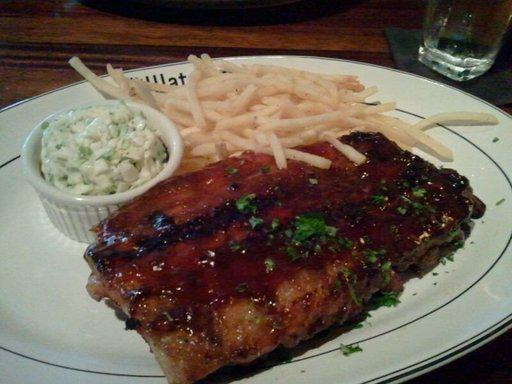

In [ ]:


train_img_path = "../dataset/train"

test_img_path = os.path.join(train_img_path, os.listdir(train_img_path)[0])



ipython_Image(filename=test_img_path) 

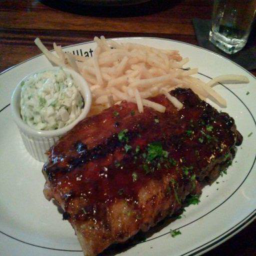

In [12]:
Image.open(test_img_path).convert('RGB')

transform = transforms.Compose([
                transforms.Resize((256, 256)),
            ])
new_img = transform(Image.open(test_img_path))

new_img

In [12]:
import os, json

config = json.load(open('./config.json'))


dict(zip(set(i.split("-")[1] for i in os.listdir(config["dataset"]["train_path"])), range(config["model"]["num_classes"])))

{'lasagna': 0,
 'prime_rib': 1,
 'club_sandwich': 2,
 'ice_cream': 3,
 'gnocchi': 4,
 'sushi': 5,
 'french_toast': 6,
 'cheesecake': 7,
 'greek_salad': 8,
 'pad_thai': 9,
 'bread_pudding': 10,
 'spaghetti_carbonara': 11,
 'lobster_bisque': 12,
 'samosa': 13,
 'french_fries': 14,
 'nachos': 15,
 'beef_carpaccio': 16,
 'donuts': 17,
 'carrot_cake': 18,
 'baby_back_ribs': 19,
 'peking_duck': 20,
 'foie_gras': 21,
 'pulled_pork_sandwich': 22,
 'scallops': 23,
 'grilled_salmon': 24,
 'waffles': 25,
 'spring_rolls': 26,
 'guacamole': 27,
 'deviled_eggs': 28,
 'red_velvet_cake': 29,
 'shrimp_and_grits': 30,
 'edamame': 31,
 'pancakes': 32,
 'bruschetta': 33,
 'churros': 34,
 'escargots': 35,
 'baklava': 36,
 'grilled_cheese_sandwich': 37,
 'steak': 38,
 'garlic_bread': 39,
 'fried_calamari': 40,
 'mussels': 41,
 'caprese_salad': 42,
 'sashimi': 43,
 'oysters': 44,
 'fried_rice': 45,
 'ceviche': 46,
 'beef_tartare': 47,
 'eggs_benedict': 48,
 'fish_and_chips': 49,
 'clam_chowder': 50,
 'seawee

In [10]:
set(i.split("-")[1] for i in os.listdir(config["dataset"]["train_path"]))

{'apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [4]:
import os, json

config = json.load(open('./config.json'))

if not config["train"]["use_wandb"]:
    print(1)

1


In [ ]:
import json, os
from PIL import Image

config = json.load(open('./config.json'))

display_num = 100
img_path = config["dataset"]["train_path"]
for i in os.listdir(img_path):
    if display_num == 0:
        break
    display_num -= 1
    print(Image.open(os.path.join(img_path, i)).size)


In [4]:
import json
import pandas as pd


origin = json.load(open('./temp.json'))


{'苹果派': {'热量': 320, '蛋白质': 4, '脂肪': 14, '碳水化合物': 48},
 '烤猪肋排': {'热量': 610, '蛋白质': 29, '脂肪': 48, '碳水化合物': 3},
 '果仁蜜饼': {'热量': 430, '蛋白质': 7, '脂肪': 22, '碳水化合物': 54},
 '生牛肉薄片': {'热量': 180, '蛋白质': 20, '脂肪': 11, '碳水化合物': 1},
 '鞑靼牛肉': {'热量': 210, '蛋白质': 18, '脂肪': 15, '碳水化合物': 2},
 '甜菜沙拉': {'热量': 120, '蛋白质': 3, '脂肪': 7, '碳水化合物': 14},
 '法式甜甜圈': {'热量': 280, '蛋白质': 5, '脂肪': 15, '碳水化合物': 32},
 '石锅拌饭': {'热量': 550, '蛋白质': 17, '脂肪': 22, '碳水化合物': 68},
 '面包布丁': {'热量': 390, '蛋白质': 8, '脂肪': 18, '碳水化合物': 49},
 '早餐卷饼': {'热量': 450, '蛋白质': 19, '脂肪': 25, '碳水化合物': 37},
 '意式烤面包': {'热量': 150, '蛋白质': 5, '脂肪': 8, '碳水化合物': 16},
 '凯撒沙拉': {'热量': 240, '蛋白质': 9, '脂肪': 18, '碳水化合物': 10},
 '奶油甜馅煎饼卷': {'热量': 330, '蛋白质': 6, '脂肪': 16, '碳水化合物': 42},
 '卡普里沙拉': {'热量': 160, '蛋白质': 6, '脂肪': 12, '碳水化合物': 8},
 '胡萝卜蛋糕': {'热量': 410, '蛋白质': 5, '脂肪': 20, '碳水化合物': 54},
 '酸橘汁腌鱼': {'热量': 190, '蛋白质': 22, '脂肪': 7, '碳水化合物': 12},
 '芝士蛋糕': {'热量': 350, '蛋白质': 6, '脂肪': 24, '碳水化合物': 29},
 '奶酪拼盘': {'热量': 380, '蛋白质': 20, '脂肪': 30, '碳水化合物': 2},
 '咖

In [15]:
import torch

if torch.cuda.is_available():
    # 获取当前使用的 GPU 设备编号
    current_device = torch.cuda.current_device()
    # 获取该 GPU 的具体型号
    gpu_name = torch.cuda.get_device_name(current_device)
    print(f"当前正在使用的 GPU 型号是: {gpu_name}")
else:
    print("当前没有可用的 GPU，正在使用 CPU 进行推理。")

当前正在使用的 GPU 型号是: NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
import os, json, time
import torch
from PIL import Image
from data.transform import FoodImageTransform
from model import Model
config = json.load(open("config.json", "r", encoding="utf-8"))

model_state_path = "./vit_128_0.0001_0.2_DA-2-20250330143538-best_model.pth"

# 加载模型
model = Model(config["inference"]["name"]).get_model()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 读取模型参数
if not os.path.exists(model_state_path):
    raise FileNotFoundError(f"not found model state file: {model_state_path}")

state_dict = torch.load(model_state_path, map_location=device)
model.load_state_dict(state_dict)


model.to(device)
model.eval()


VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.2, inplace=False)
  (blocks): ModuleList(
    (0-7): 8 x TransformerBlock(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (proj_drop): Dropout(p=0.2, inplace=False)
      )
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=512, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=512, bias=True)
        (drop): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (head): Sequential(
    (0): Linear(in_f

In [7]:
def inference(image_path):
    start_time = time.time()
    # 加载图像
    image = Image.open(image_path).convert("RGB")
    # 图像预处理
    image_tensor = FoodImageTransform(transform_type=0)(image).unsqueeze(0).to(device)# 添加批次维度并移动到GPU

    # 推理
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
        
    # 获取最可能类别的索引和置信度
    confidence, class_idx = torch.max(probabilities, 0)
    confidence_value = confidence.item() * 100
    print(f"time: {time.time() - start_time:.2f} s, class_idx: {class_idx.item()}, confidence_value: {(confidence_value):.2f}%")

val_dir = config["train"]["dataset"]["val_path"]
for loc, i in enumerate(os.listdir(val_dir)):
    print(f"[{loc}/{len(os.listdir(val_dir))}] file name: {i}", end=" ")
    inference(os.path.join(val_dir, i))


[0/6660] file name: img-0-13113t1.jpg time: 0.10 s, class_idx: 0, confidence_value: 100.00%
[1/6660] file name: img-0-13113t2.jpg time: 0.01 s, class_idx: 0, confidence_value: 99.99%
[2/6660] file name: img-0-13115t1.jpg time: 0.01 s, class_idx: 0, confidence_value: 99.97%
[3/6660] file name: img-0-13115t2.jpg time: 0.01 s, class_idx: 0, confidence_value: 99.66%
[4/6660] file name: img-0-13123t1.jpg time: 0.01 s, class_idx: 0, confidence_value: 99.98%
[5/6660] file name: img-0-13123t2.jpg time: 0.01 s, class_idx: 0, confidence_value: 100.00%
[6/6660] file name: img-0-13126t1.jpg time: 0.01 s, class_idx: 0, confidence_value: 99.96%
[7/6660] file name: img-0-13126t2.jpg time: 0.01 s, class_idx: 0, confidence_value: 99.67%
[8/6660] file name: img-0-13139t1.jpg time: 0.01 s, class_idx: 0, confidence_value: 71.11%
[9/6660] file name: img-0-13139t2.jpg time: 0.01 s, class_idx: 0, confidence_value: 99.99%
[10/6660] file name: img-0-13151t1.jpg time: 0.01 s, class_idx: 0, confidence_value: 60.

In [1]:
import json
json.load(open("food-info.json", "r", encoding="utf-8"))

{'0': {'chn': '苦瓜炒豆腐', 'calories': 320, 'protein': 4, 'fat': 14, 'carb': 48},
 '1': {'chn': '泰式绿咖喱', 'calories': 550, 'protein': 30, 'fat': 45, 'carb': 3},
 '2': {'chn': '卤肉面', 'calories': 330, 'protein': 6, 'fat': 22, 'carb': 30},
 '3': {'chn': '鸡蛋羹', 'calories': 250, 'protein': 18, 'fat': 20, 'carb': 0},
 '4': {'chn': '蛋奶冻类甜品', 'calories': 250, 'protein': 18, 'fat': 20, 'carb': 0},
 '5': {'chn': '韩式部队火锅', 'calories': 280, 'protein': 20, 'fat': 22, 'carb': 2},
 '6': {'chn': '韩式石锅拌饭', 'calories': 120, 'protein': 4, 'fat': 7, 'carb': 12},
 '7': {'chn': '肉酱盖饭', 'calories': 280, 'protein': 5, 'fat': 15, 'carb': 32},
 '8': {'chn': '什锦炒饭', 'calories': 430, 'protein': 16, 'fat': 18, 'carb': 52},
 '9': {'chn': '炒粉丝', 'calories': 350, 'protein': 8, 'fat': 12, 'carb': 52},
 '10': {'chn': '海鲜饭', 'calories': 380, 'protein': 18, 'fat': 20, 'carb': 35},
 '11': {'chn': '汤面', 'calories': 320, 'protein': 4, 'fat': 14, 'carb': 48},
 '12': {'chn': '鱼糕棒', 'calories': 550, 'protein': 30, 'fat': 45, 'carb'